In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (64598, 56, 56)   out (64598, 24, 24)
in (8075, 56, 56)   out (8075, 24, 24)


In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(64598, 56, 56, 1) (64598, 24, 24, 1)
(8075, 56, 56, 1) (8075, 24, 24, 1)


In [7]:
# def fixed_generator(x_train, y_train, batch_size):
#     while True:
#         batch_list_x = []
#         batch_list_y = []
        
#         for i in range(x_train.shape[0]):
#             batch_list_x.append(x_train[i])
#             batch_list_y.append(y_train[i])
#             if len(batch_list_x) == batch_size:
#                 yield (np.array(batch_list_x),np.array(batch_list_y))
#                 batch_list_x = []
#                 batch_list_y = []

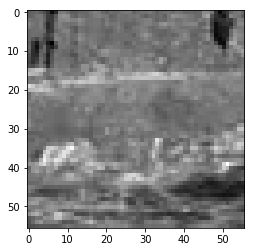

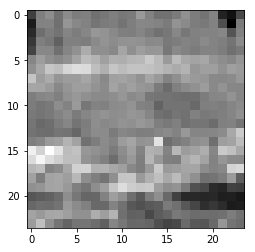

In [7]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [8]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [10]:
model_version_previous = '0.1.0.0.0_decoder_datagen_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24'
brief_ae_previous = load_model(base_dir + '/brief_ae_' + model_version_previous + '.h5')
print(brief_ae_previous.get_layer(index=7).get_weights()[0].shape)
for i in range(7, len(brief_ae.layers)):
    print(brief_ae_previous.get_layer(index=i))
    brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

(512, 1152)


In [11]:
# brief_ae_previous = load_model('/scratch/image_datasets/2_for_learned_brief/ready/brief_ae_0.0.2.1.1_whole_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24_train50more.h5')
# # print(brief_ae_previous.get_layer(index=7).get_weights()[0].shape)
# for i in range(len(brief_ae.layers)):
#     print(brief_ae_previous.get_layer(index=i))
#     brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [12]:
image_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=False, fill_mode="nearest")

In [26]:
model_version = '0.1.0.0.2_whole_datagen_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24_trainanother50more'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = brief_ae.fit_generator(image_datagen.flow(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
64598/64598 [==============================] - 2621s 41ms/step - loss: 0.5657 - val_loss: 0.5777
Epoch 2/50
64598/64598 [==============================] - 2620s 41ms/step - loss: 0.5657 - val_loss: 0.5982
Epoch 3/50
64598/64598 [==============================] - 2620s 41ms/step - loss: 0.5657 - val_loss: 0.5616
Epoch 4/50
64598/64598 [==============================] - 2623s 41ms/step - loss: 0.5656 - val_loss: 0.5691
Epoch 5/50
64598/64598 [==============================] - 2624s 41ms/step - loss: 0.5656 - val_loss: 0.5603
Epoch 6/50
64598/64598 [==============================] - 2621s 41ms/step - loss: 0.5656 - val_loss: 0.5600
Epoch 7/50
64598/64598 [==============================] - 2622s 41ms/step - loss: 0.5655 - val_loss: 0.5731
Epoch 8/50
64598/64598 [==============================] - 2622s 41ms/step - loss: 0.5655 - val_loss: 0.5691
Epoch 9/50
64598/64598 [==============================] - 2624s 41ms/step - loss: 0.5655 - val_loss: 0.5514
Epoch 10/50
64598/64598 [===

In [27]:
history_callback.history

{'val_loss': [0.577655553817749,
  0.5981665849685669,
  0.5615953207015991,
  0.5691125392913818,
  0.5602757334709167,
  0.559964120388031,
  0.5730679631233215,
  0.5690566301345825,
  0.5513746738433838,
  0.5962292551994324,
  0.565717875957489,
  0.5547640919685364,
  0.5773046016693115,
  0.5851198434829712,
  0.5766249895095825,
  0.5485212206840515,
  0.59738689661026,
  0.5476226806640625,
  0.5646010041236877,
  0.5799663066864014,
  0.5894091725349426,
  0.5762268900871277,
  0.5862033367156982,
  0.5815417170524597,
  0.576405942440033,
  0.5380480289459229,
  0.5428864359855652,
  0.548975944519043,
  0.5657832622528076,
  0.557317316532135,
  0.570989727973938,
  0.5343217849731445,
  0.5481874346733093,
  0.5484241843223572,
  0.528080403804779,
  0.6015846729278564,
  0.5481805205345154,
  0.5608876943588257,
  0.5962475538253784,
  0.5422465205192566,
  0.49542680382728577,
  0.5429072380065918,
  0.5738620162010193,
  0.5558992028236389,
  0.5813833475112915,
  0.510

predictions: 


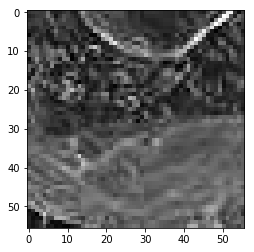

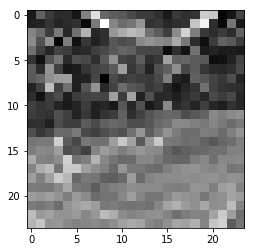

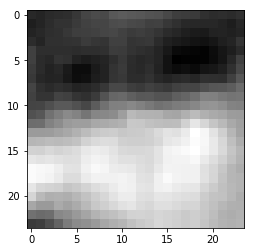

26.554324105381966

 next


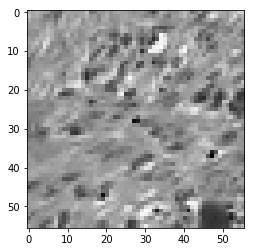

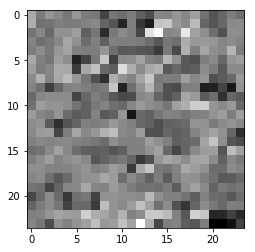

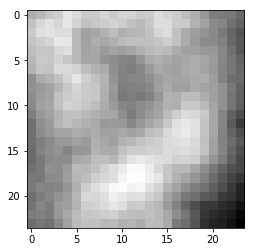

24.042111709713936

 next


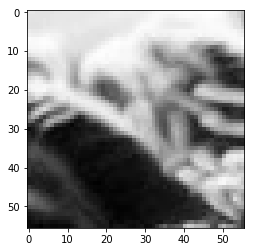

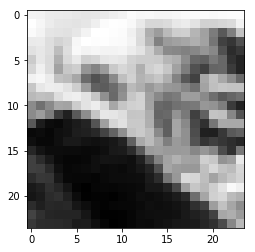

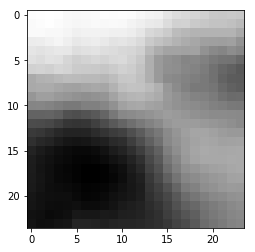

39.17331397533417

 next


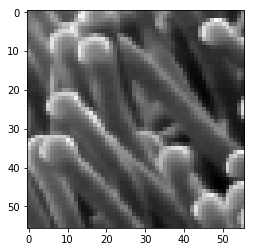

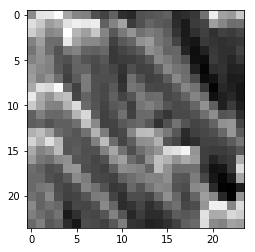

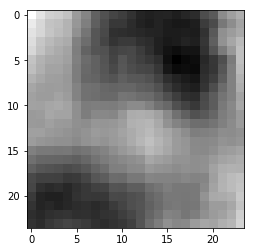

22.858724109828472

 next


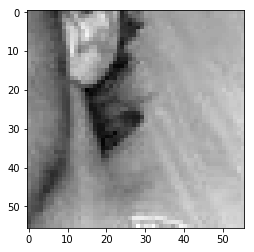

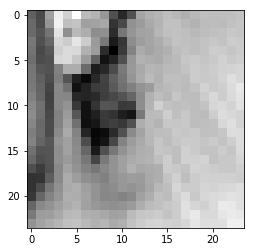

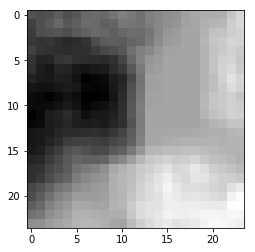

13.200893495231867

 next


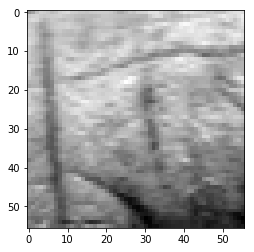

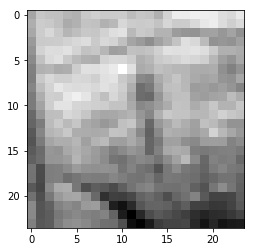

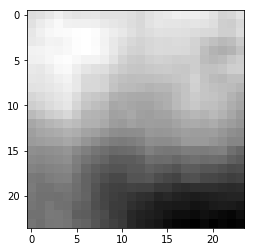

12.033452689647675

 next


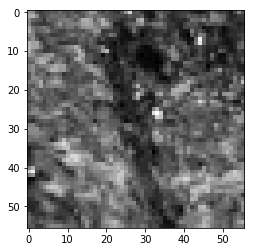

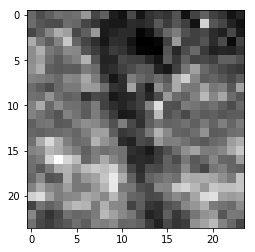

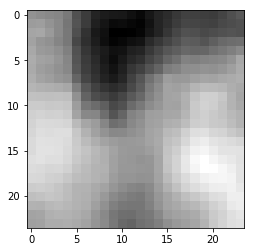

30.57451218366623

 next


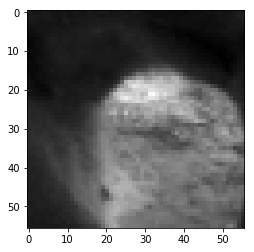

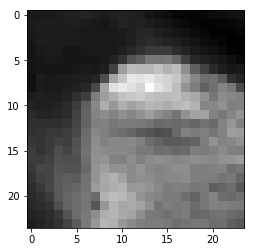

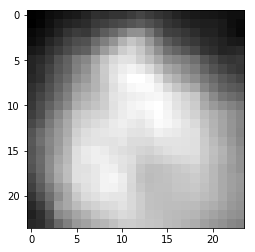

28.440263606607914

 next


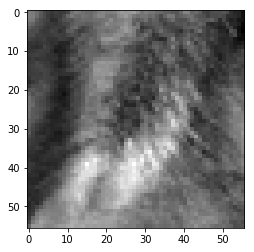

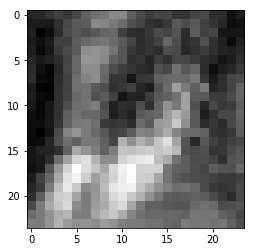

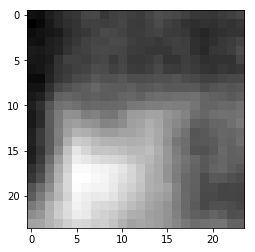

11.151776500046253

 next


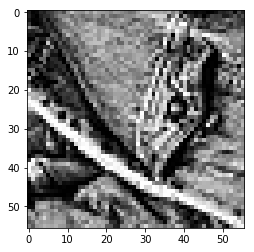

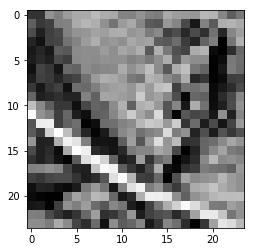

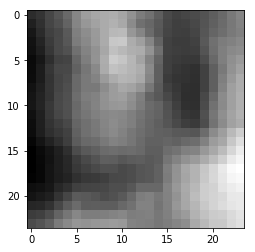

59.94634710252285

 next


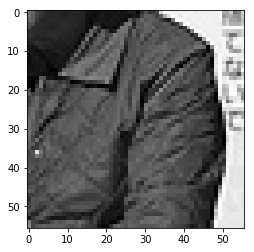

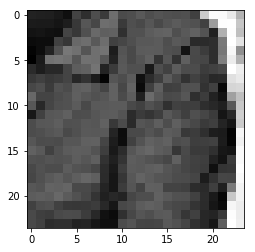

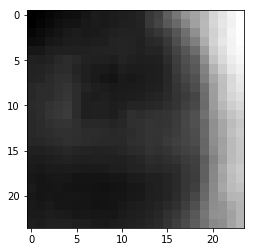

47.08718731999397

 next


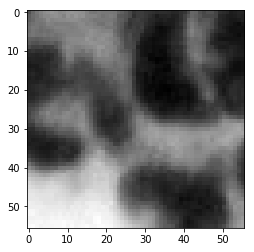

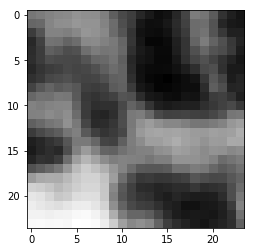

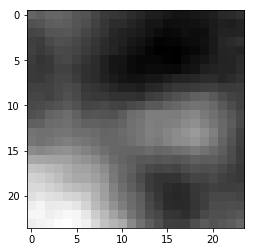

15.90837836265564

 next


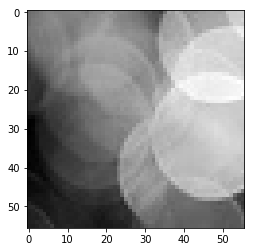

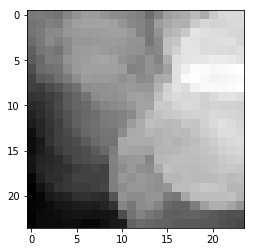

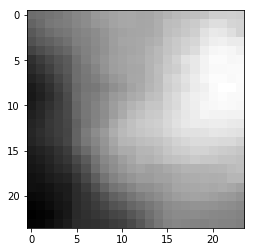

16.250268816947937

 next


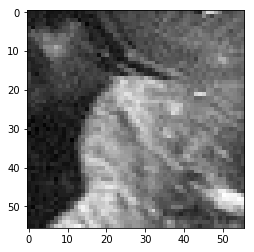

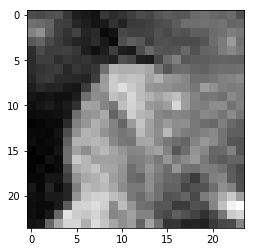

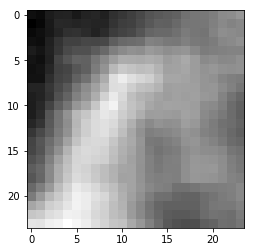

19.44097850471735

 next


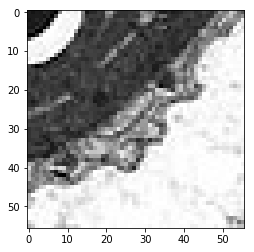

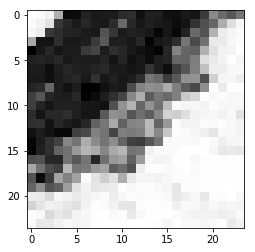

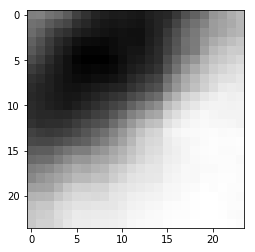

35.201884880661964

 next


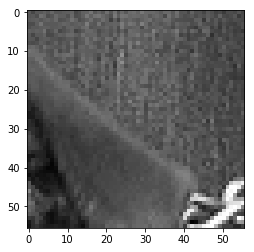

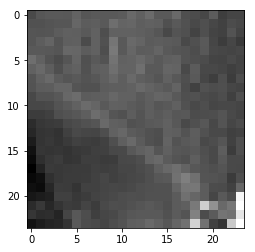

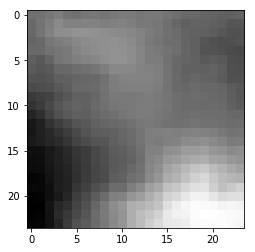

18.916011974215508

 next


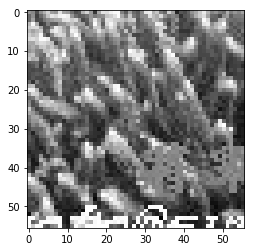

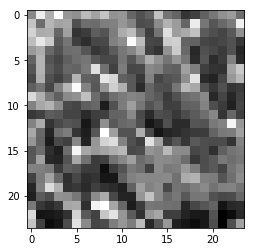

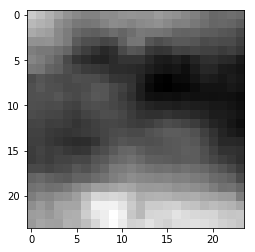

40.604552775621414

 next


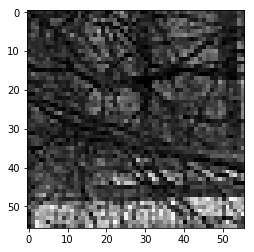

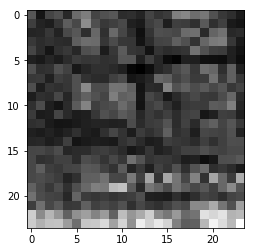

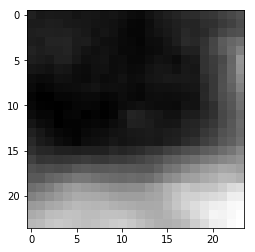

32.95117825269699

 next


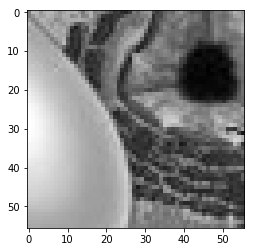

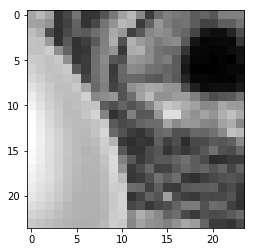

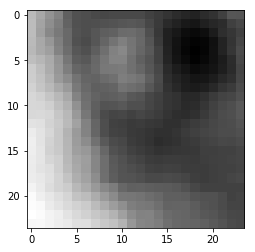

32.00987756252289

 next


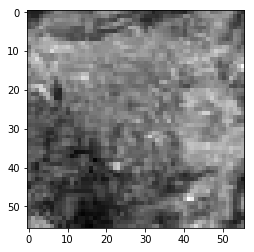

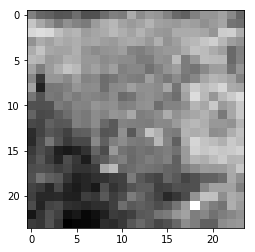

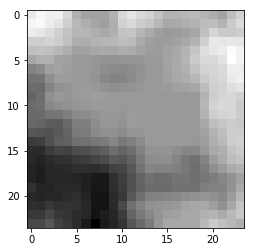

8.356810826808214

 next


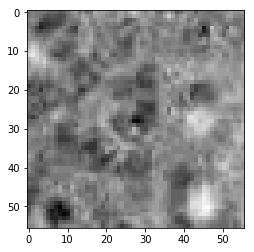

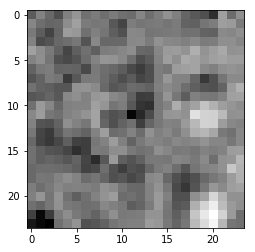

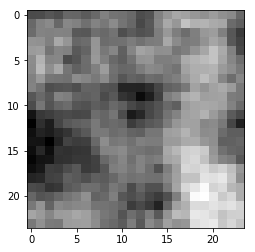

9.683541934937239

 next


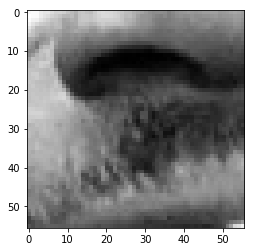

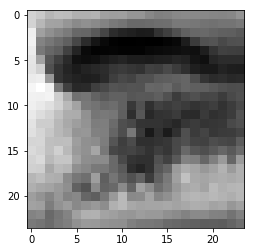

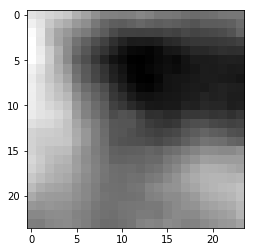

21.057079285383224

 next


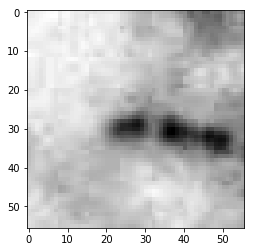

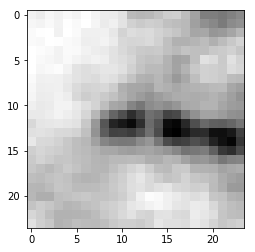

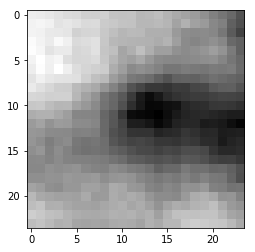

16.244128346443176

 next


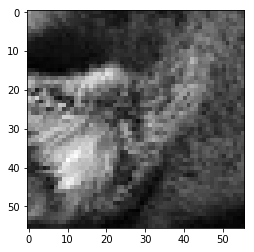

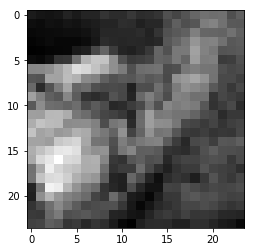

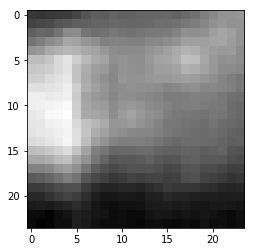

25.921602956950665

 next


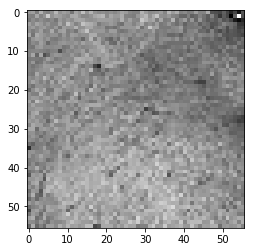

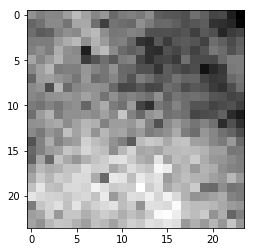

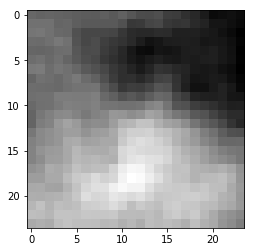

14.02149461209774

 next


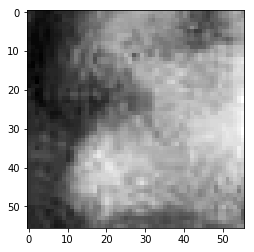

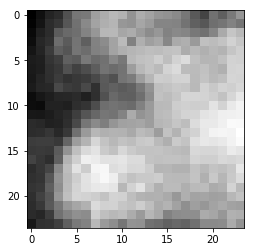

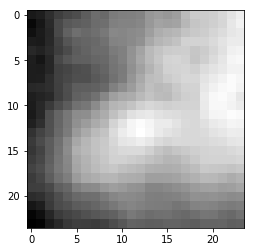

11.15910915657878

 next


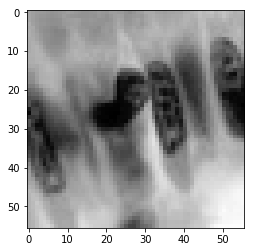

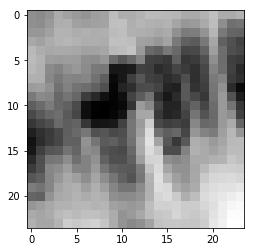

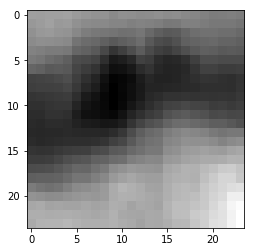

28.7942773103714

 next


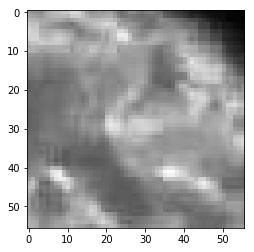

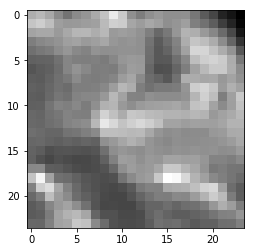

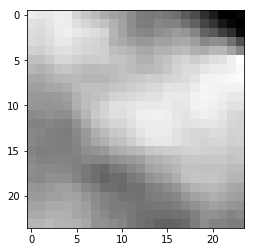

15.964106172323227

 next


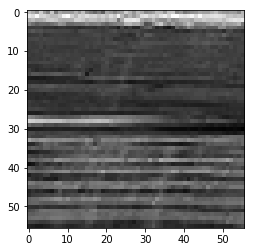

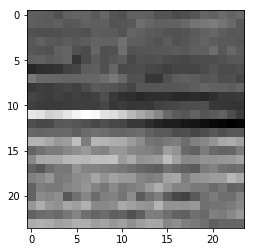

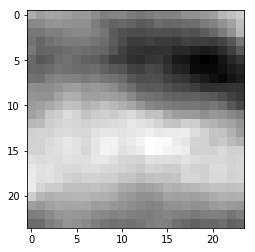

16.06738843023777

 next


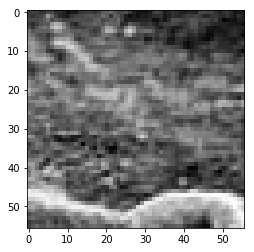

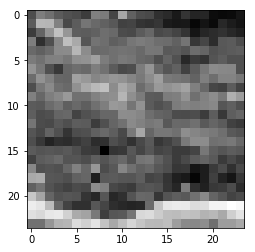

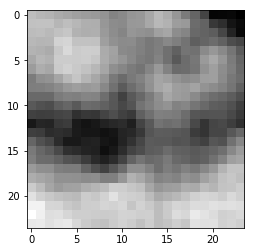

25.235346481204033

 next


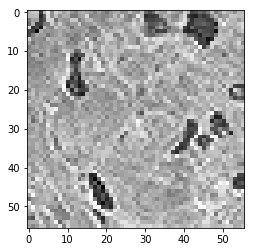

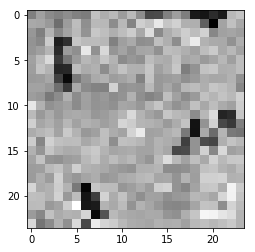

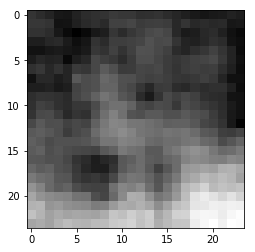

28.05686227977276

 next


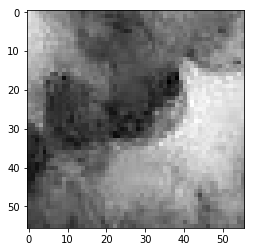

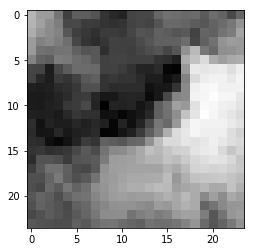

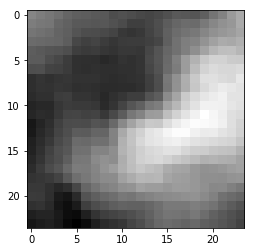

15.381345693022013

 next


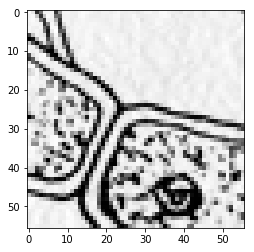

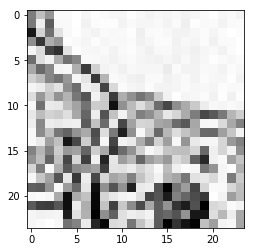

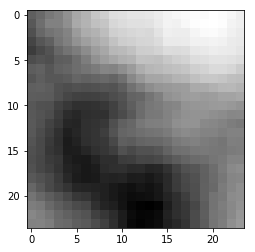

53.67573358118534

 next


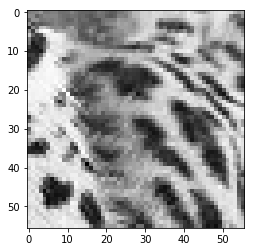

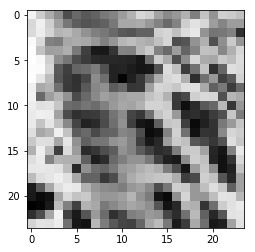

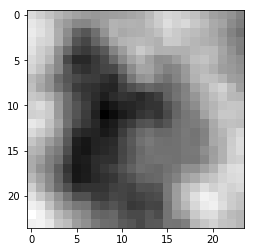

48.31817306578159

 next


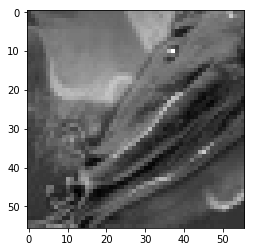

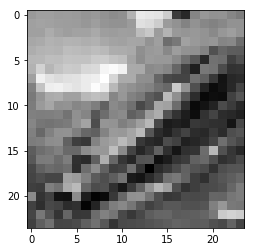

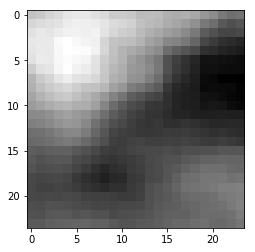

19.92400098592043

 next


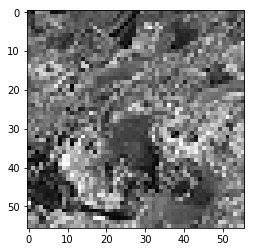

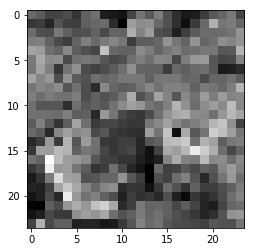

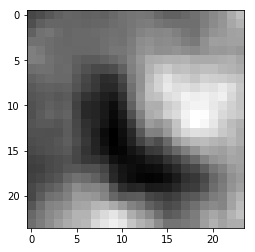

36.005670949816704

 next


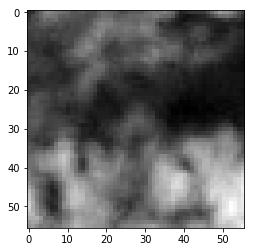

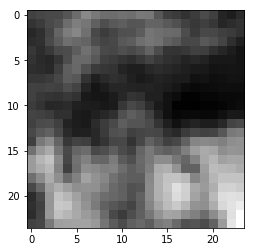

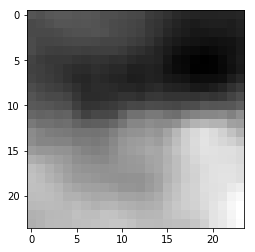

28.309011049568653

 next


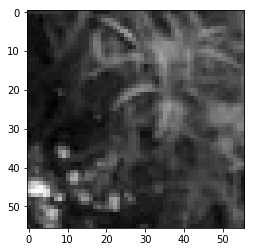

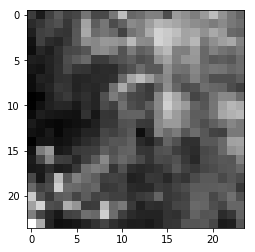

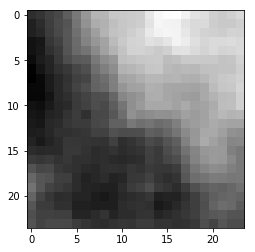

15.365502443164587

 next


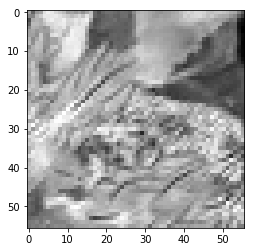

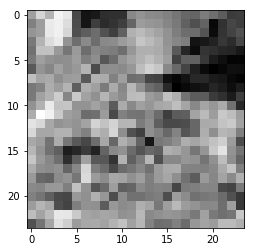

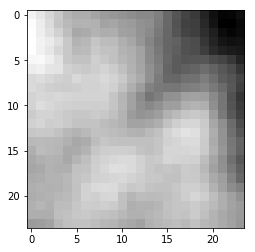

30.415969491004944

 next


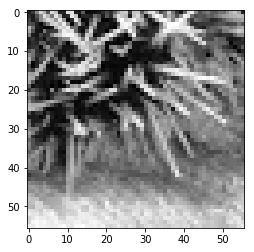

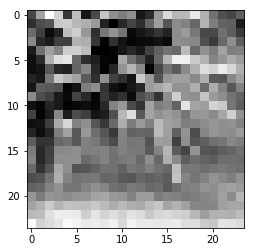

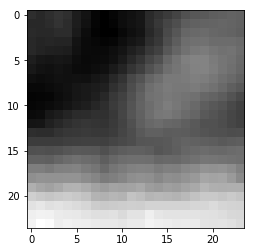

44.959343299269676

 next


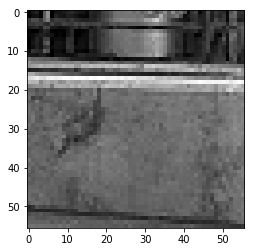

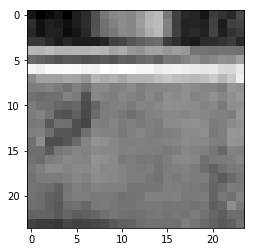

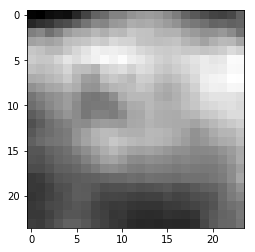

30.48711307346821

 next


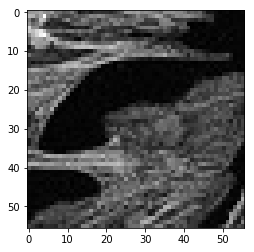

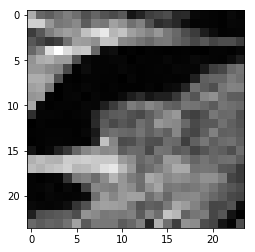

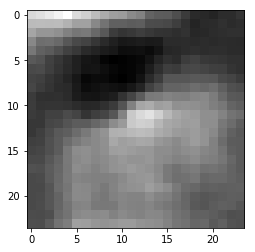

18.973197005689144

 next


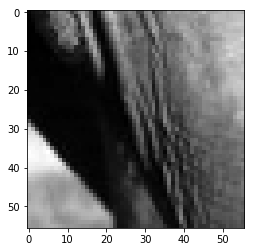

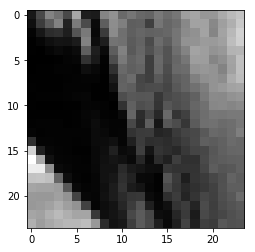

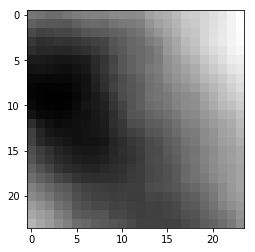

23.94034367054701

 next


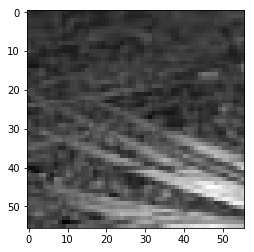

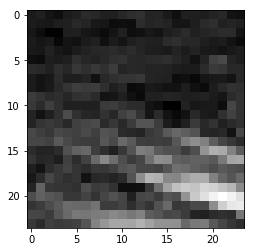

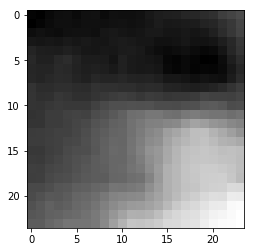

21.33773982524872

 next


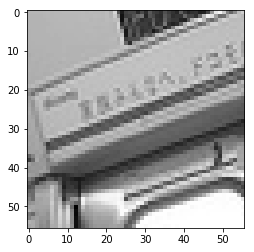

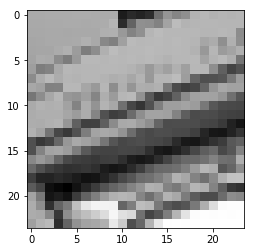

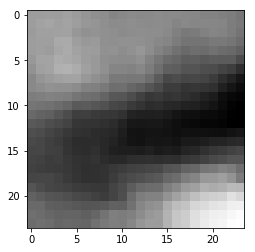

39.100912660360336

 next


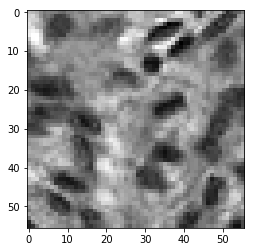

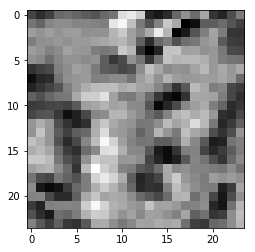

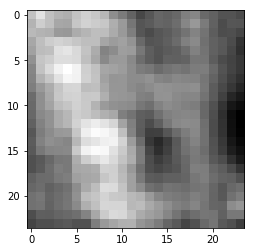

29.297980181872845

 next


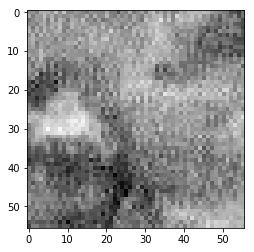

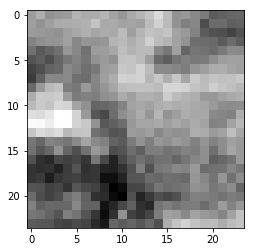

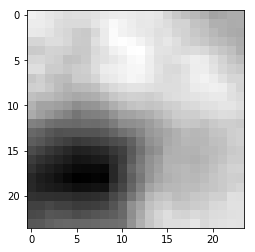

28.363380432128906

 next


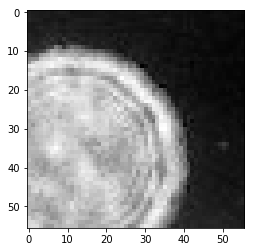

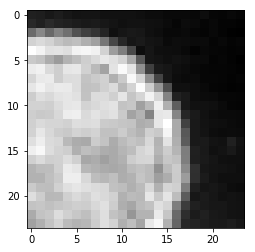

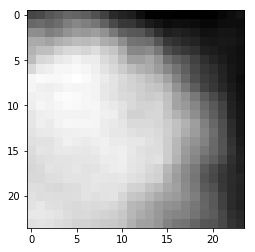

21.62168338894844

 next


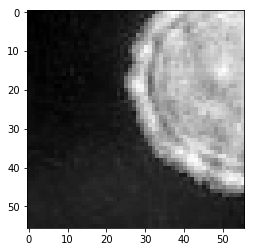

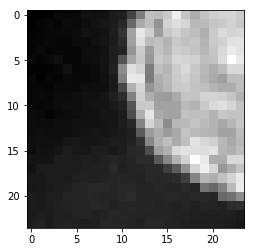

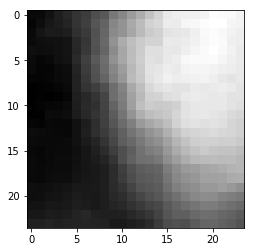

19.864006005227566

 next


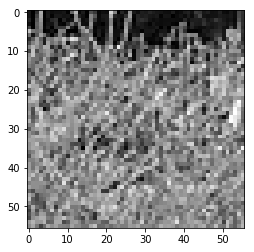

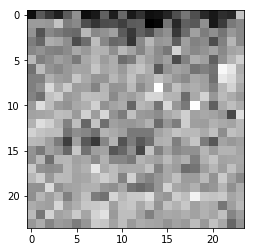

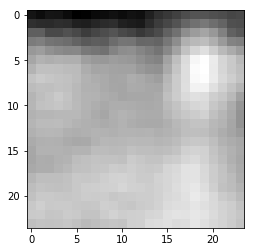

27.94777773320675

 next


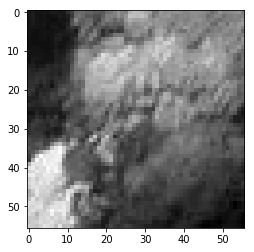

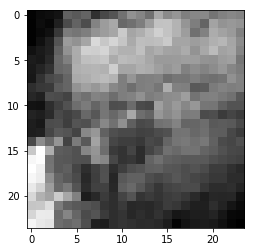

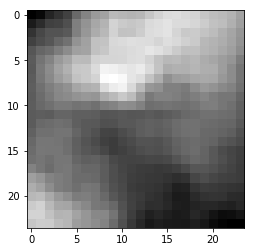

14.155763257294893

 next


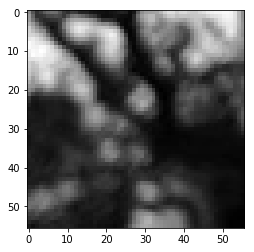

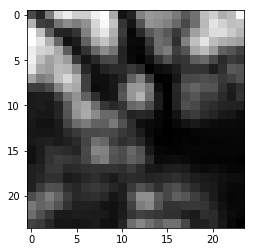

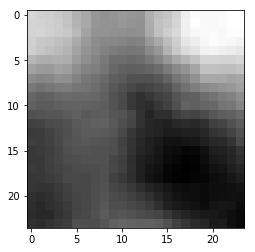

31.814100667834282

 next


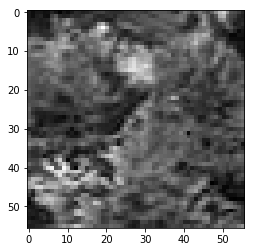

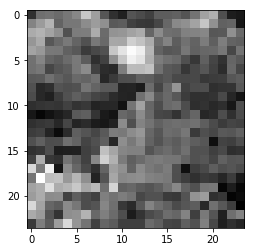

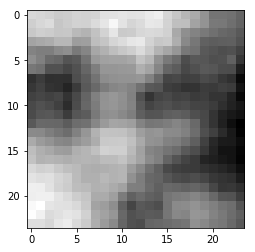

20.178045853972435

 next


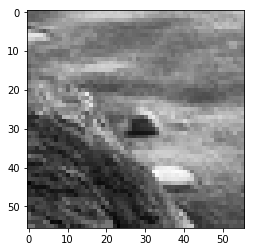

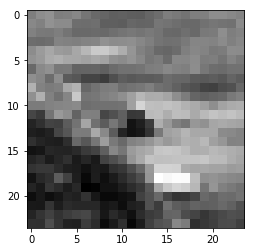

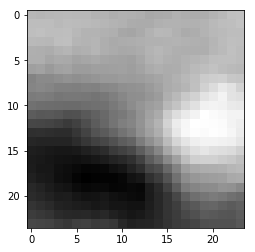

26.478005200624466

 next


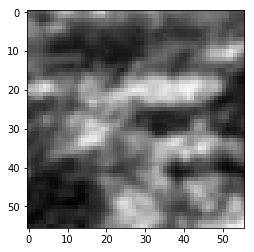

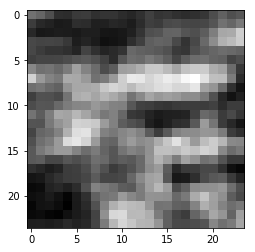

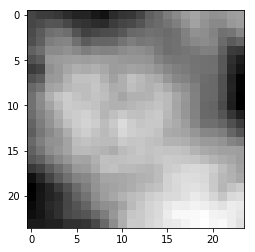

22.01642520725727

 next


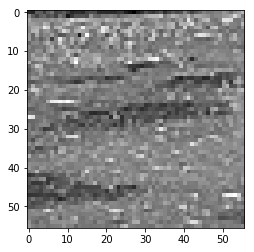

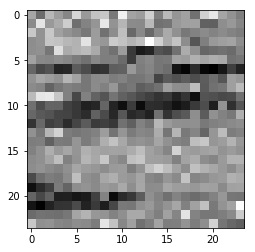

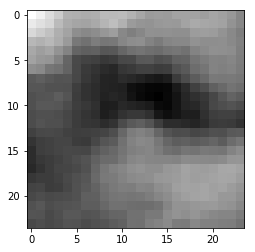

21.354818008840084

 next


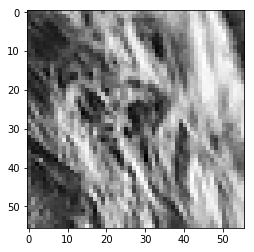

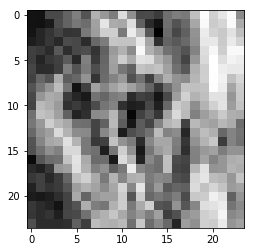

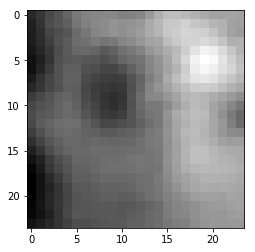

44.492097571492195

 next


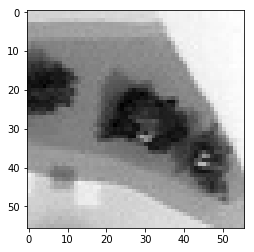

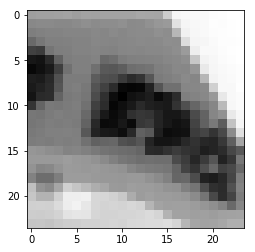

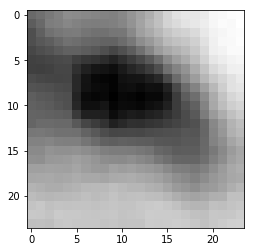

28.8461996242404

 next


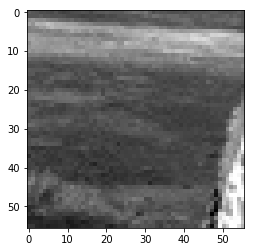

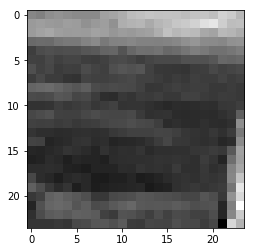

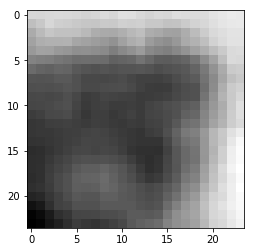

24.23321295529604

 next


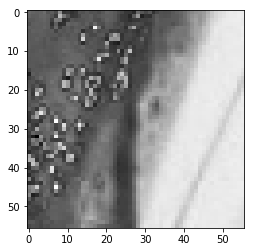

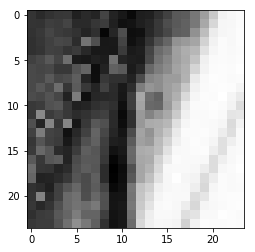

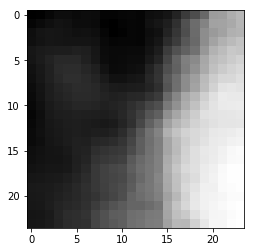

23.83907910436392

 next


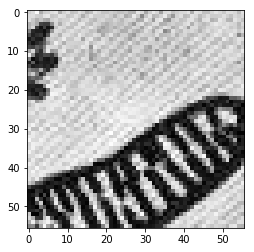

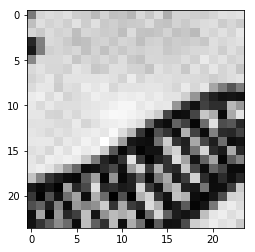

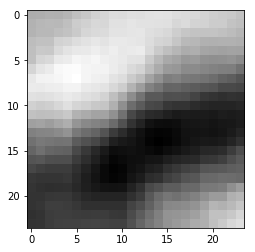

53.46645601093769

 next


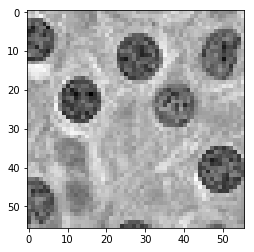

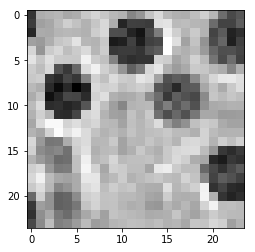

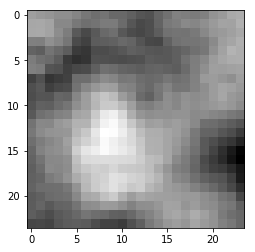

35.414206087589264

 next


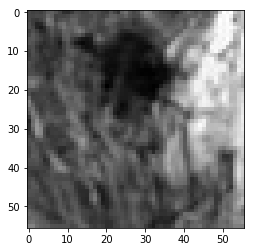

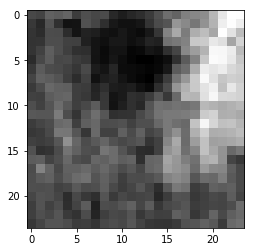

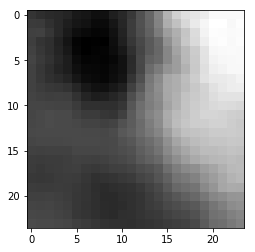

32.09759585559368

 next


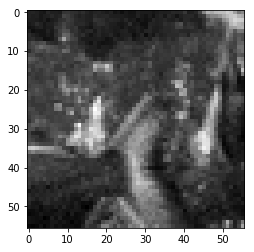

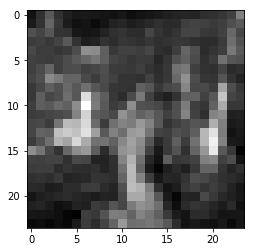

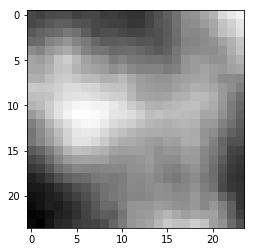

21.98973923921585

 next


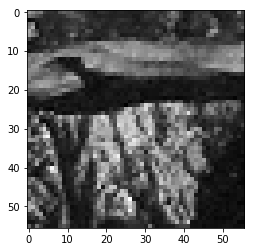

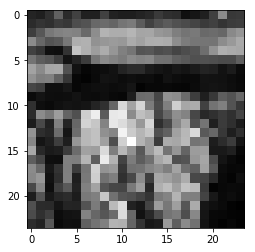

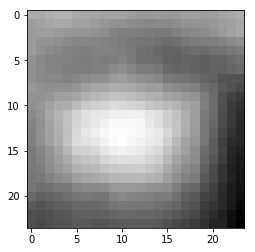

39.29929621517658

 next


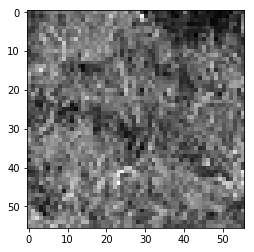

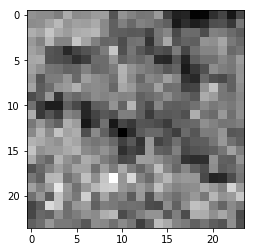

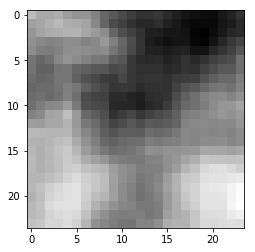

19.137705378234386

 next


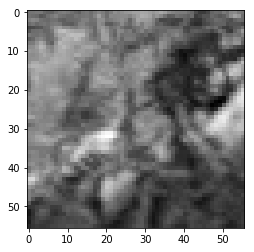

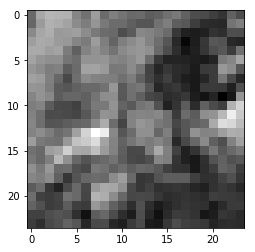

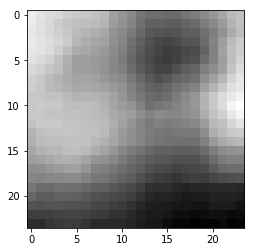

24.439665377140045

 next


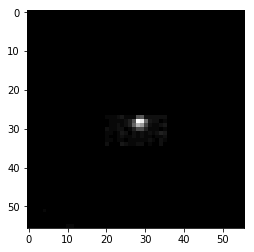

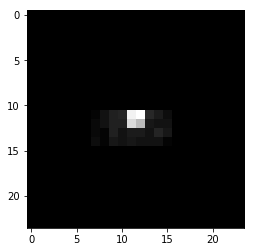

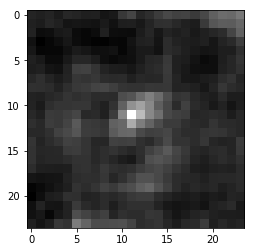

2.6340357586741447

 next


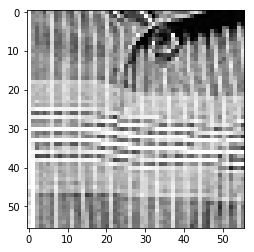

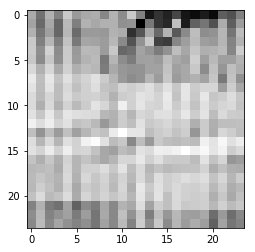

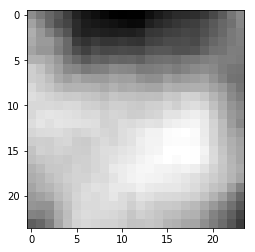

30.660125389695168

 next


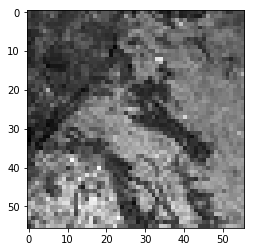

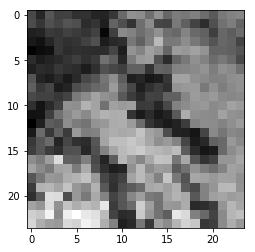

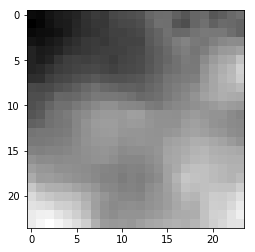

21.26088134944439

 next


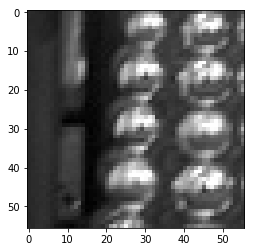

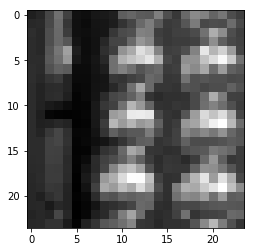

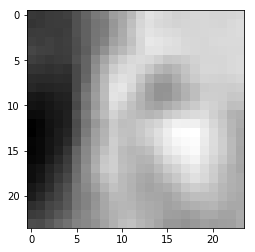

48.35180506110191

 next


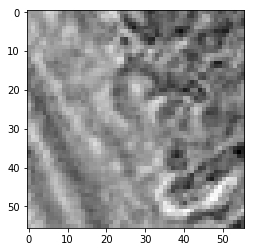

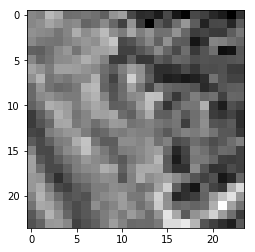

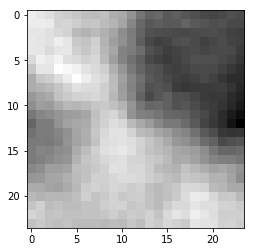

21.491027399897575

 next


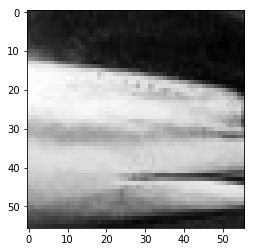

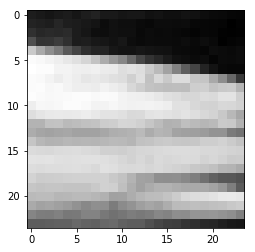

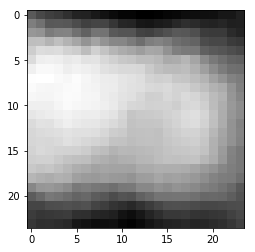

46.59177750349045

 next


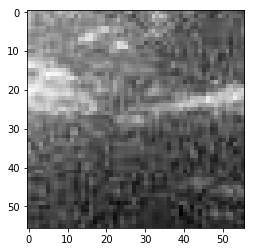

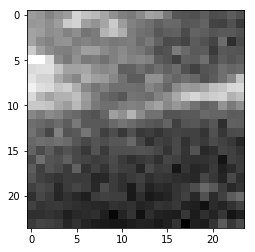

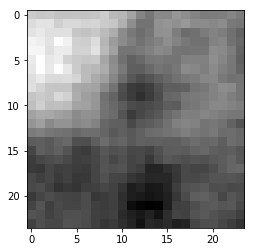

9.842184372246265

 next


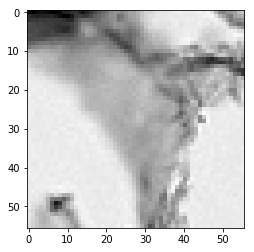

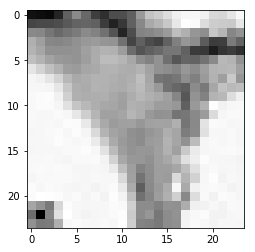

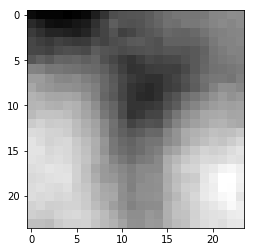

26.822557412087917

 next


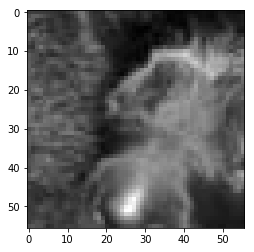

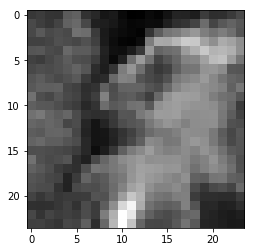

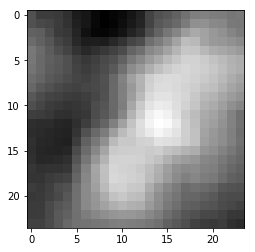

27.895070761442184

 next


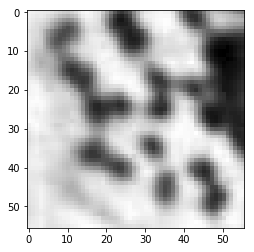

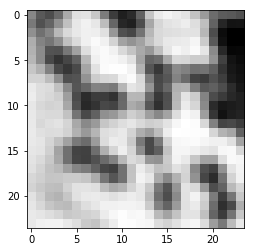

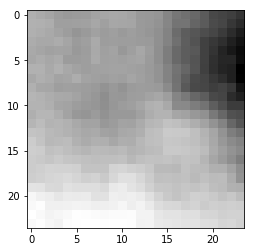

30.306130684912205

 next


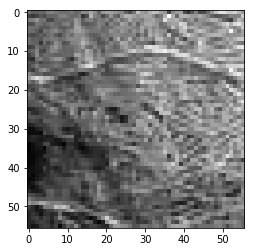

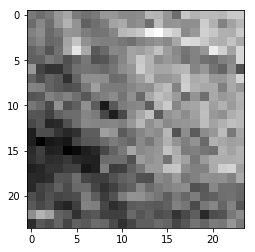

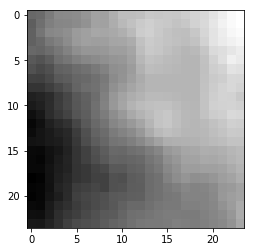

15.767351780086756

 next


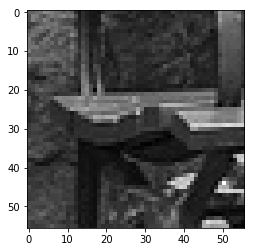

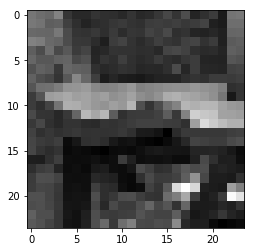

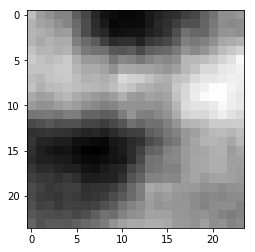

23.12138121575117

 next


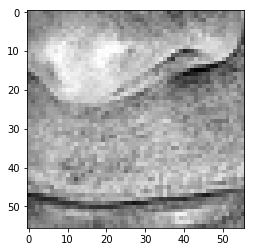

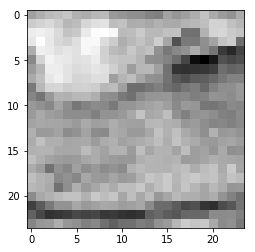

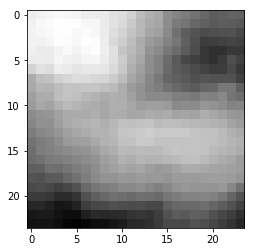

27.79995046555996

 next


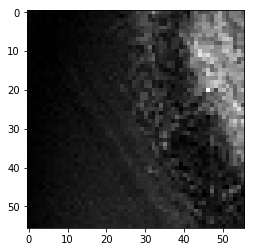

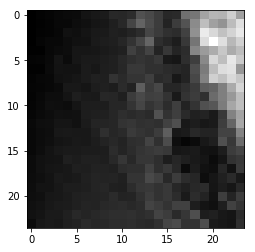

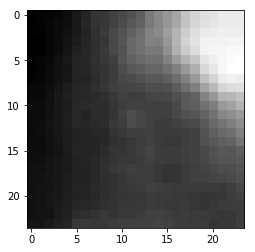

16.859951801598072

 next


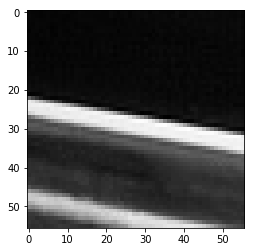

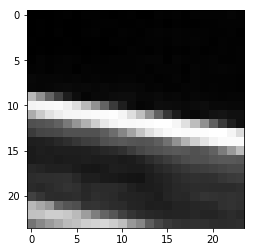

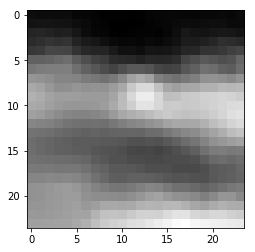

64.40595120191574

 next


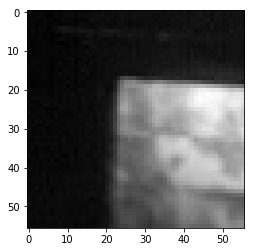

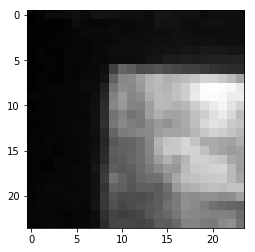

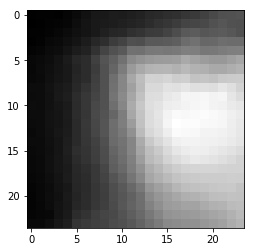

25.417294017970562

 next


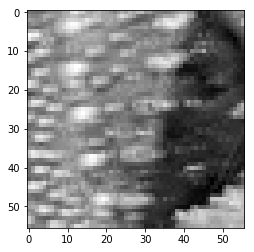

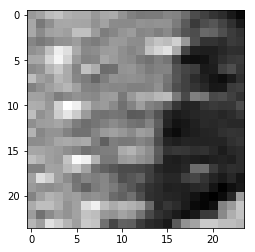

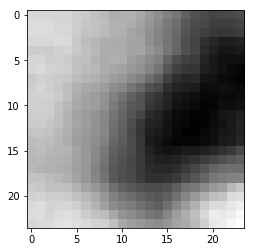

30.705588050186634

 next


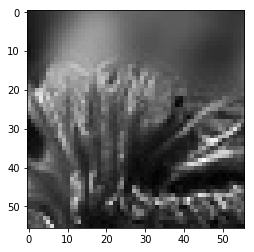

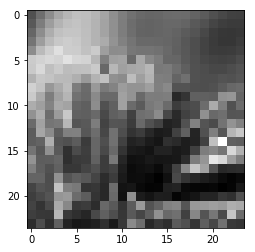

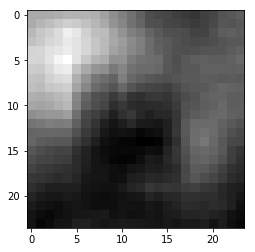

20.028582774102688

 next


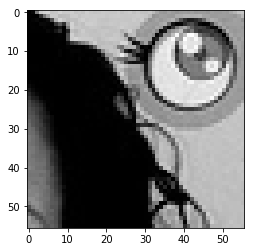

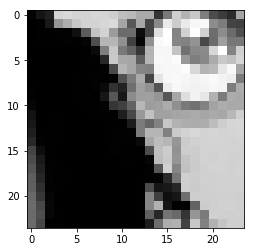

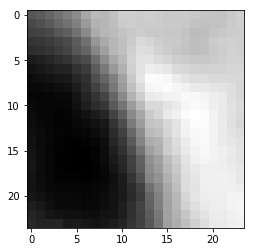

36.70842424035072

 next


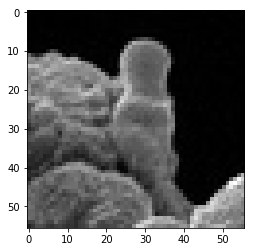

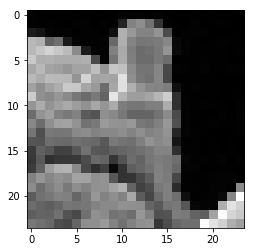

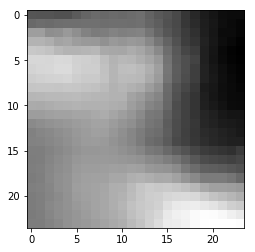

40.274958461523056

 next


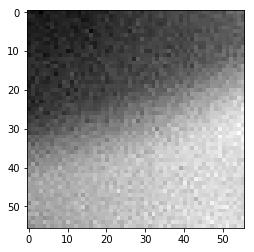

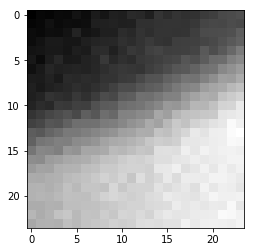

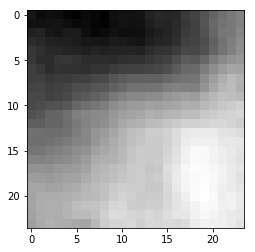

8.999211005866528

 next


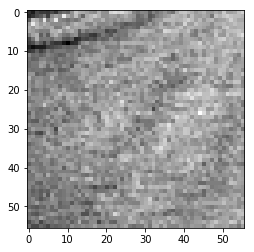

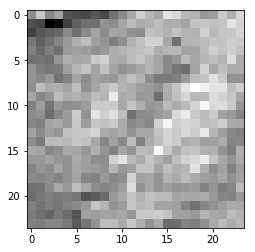

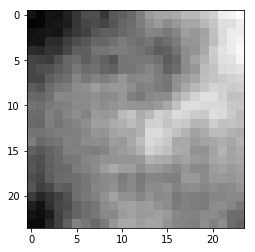

6.867981841787696

 next


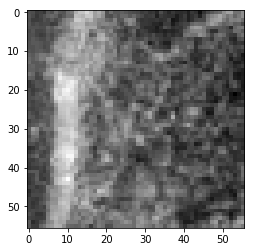

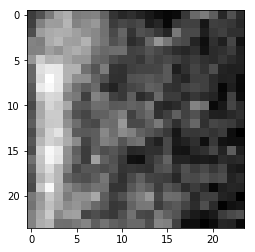

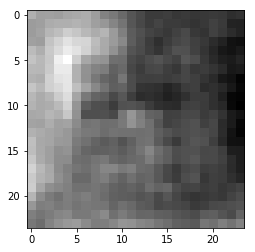

7.843463597819209

 next


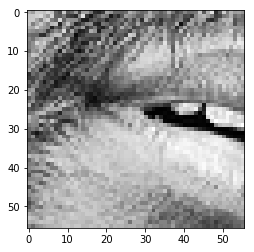

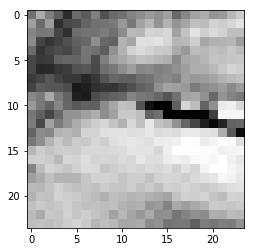

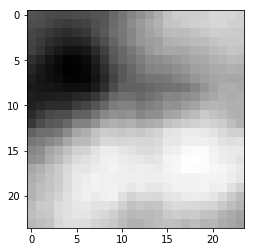

35.741942301392555

 next


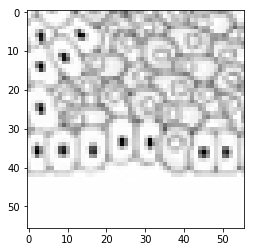

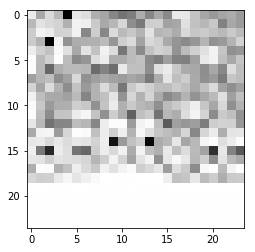

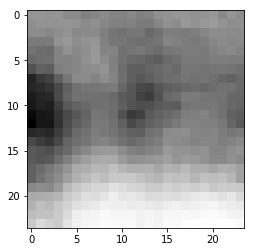

28.078802302479744

 next


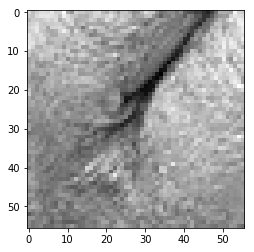

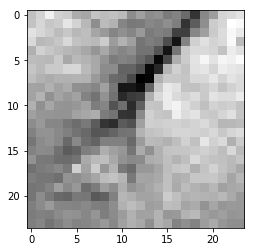

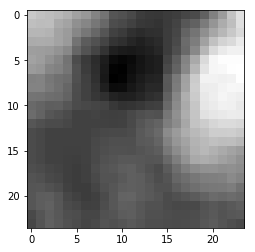

21.248600408434868

 next


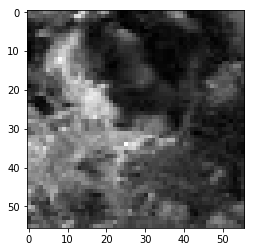

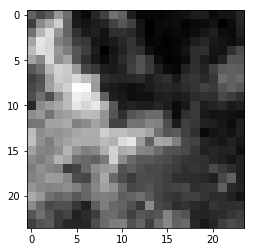

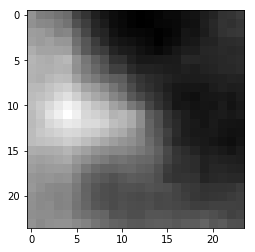

17.832519114017487

 next


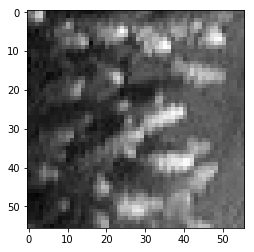

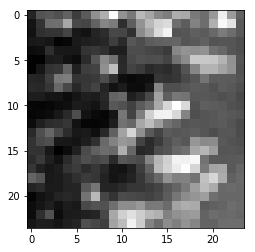

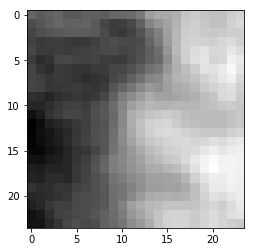

13.975960705429316

 next


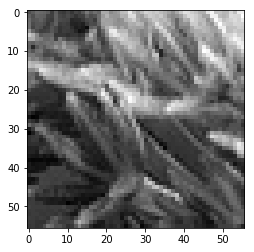

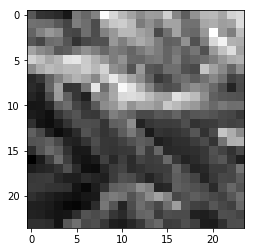

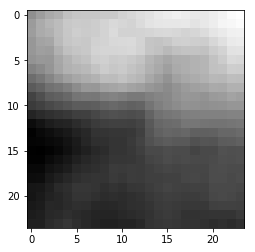

30.19156113266945

 next


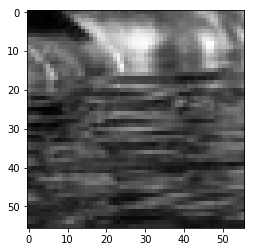

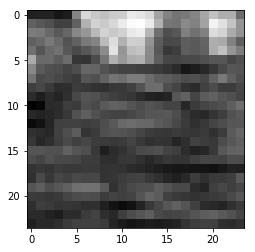

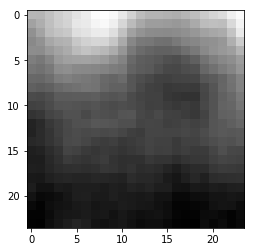

20.885336101055145

 next


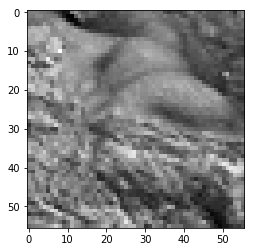

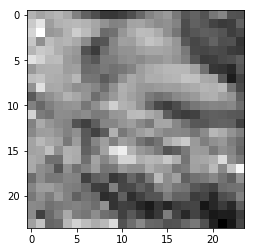

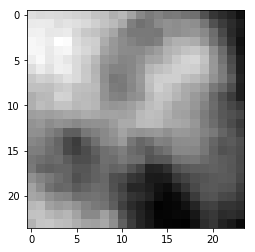

21.22555084526539

 next


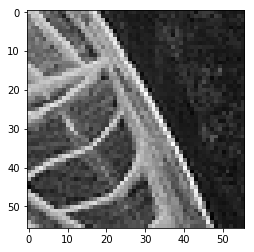

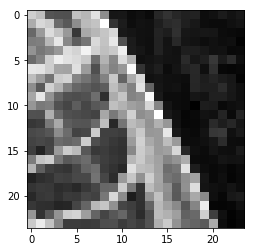

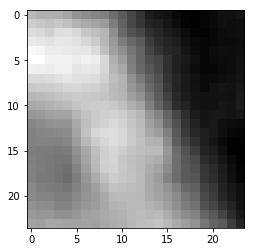

33.34476873278618

 next


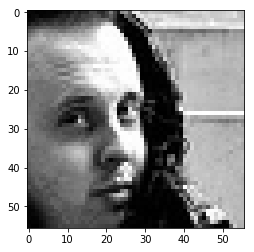

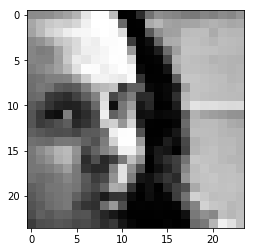

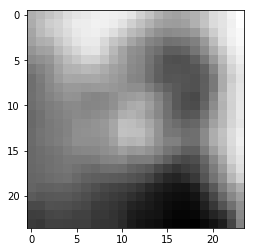

68.2552282512188

 next
0.10450529560446739


In [28]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((24, 24))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [25]:
rmses * 255

27.067417213506996

In [23]:
# input_shape_descr = (input_patch_size, input_patch_size, 1)
# input_img_descr = Input(shape=input_shape_descr)

# x_descr = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img_descr)
# x_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
# x_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
# average_blurred_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
# flattened_descr = Flatten(data_format="channels_last")(average_blurred_descr)
# briefed_descr = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened_descr)

# descr = Model(input_img_descr, briefed_descr)

In [24]:
# for i in range(len(descr.layers)):
#     descr.get_layer(index=i).set_weights(brief_ae.get_layer(index=i).get_weights())

In [25]:
# descrs = descr.predict_on_batch(np.array(images))